# Gensim Model

<h1>Inhaltsverzeichnis<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Gensim-Model" data-toc-modified-id="Gensim-Model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Gensim Model</a></span><ul class="toc-item"><li><span><a href="#Daten-einlesen,-wählen-und-vorbereiten-" data-toc-modified-id="Daten-einlesen,-wählen-und-vorbereiten--1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Daten einlesen, wählen und vorbereiten <a name="introduction"></a></a></span></li><li><span><a href="#Gensim-Modell-vorbereiten-" data-toc-modified-id="Gensim-Modell-vorbereiten--1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Gensim Modell vorbereiten <a name="paragraph0"></a></a></span></li><li><span><a href="#Topic-Modelling-aller-Daten-mit-raw-text-" data-toc-modified-id="Topic-Modelling-aller-Daten-mit-raw-text--1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Topic Modelling aller Daten mit raw text <a name="paragraph1"></a></a></span><ul class="toc-item"><li><span><a href="#Unigramm-" data-toc-modified-id="Unigramm--1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Unigramm <a name="subparagraph1"></a></a></span></li><li><span><a href="#Bigramm-" data-toc-modified-id="Bigramm--1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Bigramm <a name="subparagraph2"></a></a></span></li><li><span><a href="#Trigramm-" data-toc-modified-id="Trigramm--1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>Trigramm <a name="subparagraph3"></a></a></span></li></ul></li><li><span><a href="#Topic-Modelling-aller-Daten-mit-POS" data-toc-modified-id="Topic-Modelling-aller-Daten-mit-POS-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Topic Modelling aller Daten mit POS</a></span><ul class="toc-item"><li><span><a href="#Unigramm" data-toc-modified-id="Unigramm-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Unigramm</a></span></li><li><span><a href="#Bigramm" data-toc-modified-id="Bigramm-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Bigramm</a></span></li><li><span><a href="#Trigramm" data-toc-modified-id="Trigramm-1.4.3"><span class="toc-item-num">1.4.3&nbsp;&nbsp;</span>Trigramm</a></span></li></ul></li><li><span><a href="#Ergebnisse-erkunden-" data-toc-modified-id="Ergebnisse-erkunden--1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Ergebnisse erkunden <a name="paragraph4"></a></a></span><ul class="toc-item"><li><span><a href="#Dominante-Topics-pro-Artikels" data-toc-modified-id="Dominante-Topics-pro-Artikels-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Dominante Topics pro Artikels</a></span></li><li><span><a href="#Repräsentativstes-Dokument-pro-Topic" data-toc-modified-id="Repräsentativstes-Dokument-pro-Topic-1.5.2"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>Repräsentativstes Dokument pro Topic</a></span></li></ul></li></ul></li></ul></div>

In [1]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import Phrases

from gensim.models.phrases import Phraser
import pandas as pd

from collections import Counter
import warnings
warnings.filterwarnings('ignore')

https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

## Daten einlesen, wählen und vorbereiten <a name="introduction"></a>

In [2]:
df = pd.read_csv('../../Datensaetze/news_POS_POS_tags_nouns_adjectives_verb.csv')
df.head(1)

,category,filename,title,content,number_of_tokens,number_of_types,stemmed_text,POS_tags,POS,nouns,adjectives,verb
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,415.0,244.0,quarterli profit at US media giant timewarn j...,"['_SP', 'NNP', 'NNS', 'IN', 'NNP', 'NNS', 'NN'...",high fourth own fourth underlying exceptional ...,74.0,22.0,1.0


In [3]:
from collections import Counter

Counter(df.category)

Counter({'business': 510,
         'entertainment': 386,
         'politics': 417,
         'sport': 511,
         'tech': 401})

In [4]:
data1 = df[df['category'] == 'business']
data2 = df[df['category'] == 'entertainment']
data3 = df[df['category'] == 'tech']
data4 = df[df['category'] == 'politics']
data5 = df[df['category'] == 'sport']
genres = pd.concat([data1, data2, data3, data4, data5], axis=0)
#genres.head(1)
genres.shape

(2225, 12)

## Gensim Modell vorbereiten <a name="paragraph0"></a>

In [5]:
def create_docs(df, column):
    docs = []
    for i, row in df.iterrows():
        text = row[column].split()
        docs.append(text)
    return docs

In [6]:
def build_dictionary(docs):
    dictionary = Dictionary(docs)
    dictionary.filter_extremes(no_below=20, no_above=0.5)
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    return dictionary, corpus

In [7]:
def build_model(docs, num_topics=8, chunksize=2000, passes=20, iterations=400, eval_every=None):
    dictionary, corpus = build_dictionary(docs)
    
    temp = dictionary[0] 
    id2word = dictionary.id2token

    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every
    )
    return model, dictionary, corpus

In [8]:
# top_topics = model.top_topics(corpus) #, num_words=20)

# # Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
# avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
# print('Average topic coherence: %.4f.' % avg_topic_coherence)

# pprint(top_topics)

In [9]:
def visualise_LDA(model, corpus, dictionary):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)

In [10]:
def bi_trigramm(df, column):
    bigram_text= []
    for i, row in df.iterrows():
        text = row[column].split()
        bigram_text.append(text)

    bigram = Phrases(bigram_text, min_count=2, threshold=10) # höherer threshold für weniger phrases.
    trigram = Phrases(bigram[docs], threshold=10)  

    bigram_mod = Phraser(bigram)
    trigram_mod = Phraser(trigram)
    return bigram_text, bigram_mod, trigram_mod

## Topic Modelling aller Daten mit raw text <a name="paragraph1"></a>

### Unigramm <a name="subparagraph1"></a>

In [11]:
docs = create_docs(df, 'content')
model, dictionary, corpus = build_model(docs)

In [12]:
print('Unique tokens: %d' % len(dictionary))
print('Documents: %d' % len(corpus))
pprint(model.print_topics())

Unique tokens: 3633
Documents: 2225
[(0,
  '0.019*"his" + 0.013*"I" + 0.009*"we" + 0.009*"after" + 0.008*""I" + '
  '0.006*"first" + 0.006*"who" + 0.006*"against" + 0.006*"out" + 0.005*"when"'),
 (1,
  '0.020*"Mr" + 0.010*"-" + 0.009*"its" + 0.009*"government" + 0.006*"could" + '
  '0.006*"they" + 0.006*"about" + 0.006*"said." + 0.005*"Labour" + '
  '0.005*"more"'),
 (2,
  '0.012*"they" + 0.010*"people" + 0.009*"users" + 0.009*"or" + 0.008*"can" + '
  '0.008*"software" + 0.007*"said." + 0.007*"its" + 0.007*"about" + '
  '0.007*"more"'),
 (3,
  '0.013*"people" + 0.013*"mobile" + 0.010*"more" + 0.010*"they" + 0.009*"can" '
  '+ 0.008*"technology" + 0.008*"digital" + 0.007*"phone" + 0.007*"music" + '
  '0.006*"or"'),
 (4,
  '0.021*"you" + 0.021*"I" + 0.013*"can" + 0.012*"-" + 0.010*"more" + '
  '0.010*"or" + 0.009*"game" + 0.008*"they" + 0.007*"people" + 0.007*"my"'),
 (5,
  '0.015*"his" + 0.012*"who" + 0.011*"Mr" + 0.011*"-" + 0.009*"she" + '
  '0.009*"US" + 0.008*"best" + 0.008*"her" + 

In [13]:
# visualise_LDA(model, dictionary, corpus)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.056219  0.050950       1        1  22.739485
0      0.163208 -0.057409       2        1  21.168652
5      0.174695  0.031499       3        1  16.856911
4      0.003489 -0.098603       4        1  11.756945
3     -0.086350 -0.026000       5        1   9.548996
7     -0.084527  0.232981       6        1   8.575257
2     -0.063109 -0.030201       7        1   8.139130
6     -0.163625 -0.103217       8        1   1.214621, topic_info=     Category         Freq     Term        Total  loglift  logprob
158   Default  3025.000000       Mr  3025.000000  30.0000  30.0000
596   Default  2095.000000        I  2095.000000  29.0000  29.0000
226   Default  2157.000000     more  2157.000000  28.0000  28.0000
1192  Default  1182.000000      you  1182.000000  27.0000  27.0000
555   Default  2859.000000      his  2859.000000  26.0000  26.0000
...       ...          ...      ...          ...      ...      ...
73     Topic8    33.480576      its  2066.859131   0.2879  -4.9414
229    Topic8    25.463814     much   547.571777   1.3425  -5.2151
331    Topic8    32.761288     they  2370.937012   0.1289  -4.9632
2607   Topic8    24.238590  players   466.802856   1.4528  -5.2645
233    Topic8    26.600922      out  1388.602661   0.4556  -5.1715

[601 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
140       1  0.047585    "I
140       2  0.667227    "I
140       3  0.155169    "I
140       4  0.112756    "I
140       5  0.001034    "I
...     ...       ...   ...
1192      8  0.012690   you
1193      2  0.003114  your
1193      4  0.784613  your
1193      5  0.127655  your
1193      7  0.080952  your

[1682 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 6, 5, 4, 8, 3, 7])

In [14]:
#pyLDAvis.save_html(vis, '../../Bilder/Topic Modeling/lda_text_alles.html')

### Bigramm <a name="subparagraph2"></a>

In [15]:
bigram_text, bigram_mod, trigram_mod = bi_trigramm(df, 'content')

bigramme = [bigram_mod[doc] for doc in bigram_text]

model, dictionary, corpus = build_model(bigramme)

In [16]:
pprint(model.print_topics())

[(0,
  '0.033*"she" + 0.026*"her" + 0.013*"software" + 0.011*"had" + 0.010*"She" + '
  '0.009*"or" + 0.008*"people" + 0.007*"were" + 0.007*"-" + 0.007*"would"'),
 (1,
  '0.023*"his" + 0.019*"he" + 0.013*"I" + 0.010*"who" + 0.009*"-" + '
  '0.009*"after" + 0.009*"had" + 0.007*"their" + 0.006*"first" + 0.005*"one"'),
 (2,
  '0.010*"-" + 0.010*"not" + 0.009*"people" + 0.009*"their" + 0.009*"you" + '
  '0.009*"or" + 0.008*"they" + 0.008*"more" + 0.008*"I" + 0.007*"this"'),
 (3,
  '0.013*"or" + 0.012*"people" + 0.010*"were" + 0.009*"their" + '
  '0.009*"broadband" + 0.008*"UK" + 0.007*"more_than" + 0.007*"service" + '
  '0.007*"will_be" + 0.007*"over"'),
 (4,
  '0.011*"will_be" + 0.011*"its" + 0.011*"more" + 0.009*"technology" + '
  '0.008*"games" + 0.008*"-" + 0.008*"music" + 0.007*"new" + 0.006*"first" + '
  '0.006*"one"'),
 (5,
  '0.018*"its" + 0.017*"Apple" + 0.015*"-" + 0.014*"or" + 0.011*"people" + '
  '0.010*"new" + 0.010*"Microsoft" + 0.009*"their" + 0.008*"will_be" + '
  '0.007*"so

In [17]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.083005 -0.003093       1        1  39.087509
1      0.255947  0.071458       2        1  22.150110
2     -0.002629  0.023942       3        1  17.655737
4     -0.045164  0.108025       4        1   6.963133
3     -0.095598  0.039554       5        1   5.185071
6     -0.053130 -0.070776       6        1   4.091560
0      0.021699 -0.219696       7        1   2.492581
5     -0.164130  0.050586       8        1   2.374300, topic_info=    Category         Freq      Term        Total  loglift  logprob
61   Default  1803.000000       its  1803.000000  30.0000  30.0000
117  Default  2941.000000         -  2941.000000  29.0000  29.0000
79   Default  1413.000000        or  1413.000000  28.0000  28.0000
665  Default  1201.000000    people  1201.000000  27.0000  27.0000
461  Default  2351.000000       his  2351.000000  26.0000  26.0000
..       ...          ...       ...          ...      ...      ...
270   Topic8    42.414948      were  1529.075684   0.1555  -5.0829
363   Topic8    37.943703     about  1077.722778   0.3940  -5.1943
739   Topic8    36.250233        an  1259.394653   0.1925  -5.2399
320   Topic8    34.381069  he_said.   623.260376   0.8430  -5.2929
272   Topic8    34.635284       who  1405.307739   0.0373  -5.2855

[572 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
401       1  0.196739    "I
401       2  0.699515    "I
401       3  0.103834    "I
222       1  0.523873  "The
222       2  0.166106  "The
...     ...       ...   ...
1075      2  0.004351  your
1075      3  0.922377  your
1075      4  0.039158  your
1075      6  0.017403  your
1075      8  0.013053  your

[1567 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 3, 5, 4, 7, 1, 6])

### Trigramm <a name="subparagraph3"></a>

In [18]:
trigramme = [trigram_mod[bigram_mod[doc]] for doc in bigram_text]

model, dictionary, corpus = build_model(trigramme)

In [19]:
pprint(model.print_topics())

[(0,
  '0.052*"her" + 0.046*"she" + 0.016*"She" + 0.010*"Mr" + 0.010*"over" + '
  '0.009*"-" + 0.008*"A" + 0.008*"did_not" + 0.007*"are" + 0.007*"had"'),
 (1,
  '0.011*"government" + 0.009*"are" + 0.009*"were" + 0.007*"their" + '
  '0.007*"not" + 0.007*"will" + 0.007*"would" + 0.007*"its" + 0.006*"had" + '
  '0.006*"-"'),
 (2,
  '0.011*"are" + 0.010*"-" + 0.009*"its" + 0.009*"games" + 0.009*"more" + '
  '0.008*"new" + 0.007*"will" + 0.007*"game" + 0.006*"also" + 0.006*"or"'),
 (3,
  '0.015*"-" + 0.015*"its" + 0.010*"US" + 0.010*"are" + 0.008*"also" + '
  '0.007*"up" + 0.006*"new" + 0.006*"were" + 0.005*"will" + 0.005*"their"'),
 (4,
  '0.023*"his" + 0.015*"he" + 0.011*"-" + 0.010*"who" + 0.009*"after" + '
  '0.009*"had" + 0.006*"their" + 0.005*"not" + 0.005*"He" + 0.005*"But"'),
 (5,
  '0.014*"-" + 0.013*"I" + 0.011*"or" + 0.011*"are" + 0.010*"their" + '
  '0.010*"you" + 0.009*"my" + 0.008*"this" + 0.008*"people" + 0.007*"about"'),
 (6,
  '0.013*"its" + 0.012*"are" + 0.012*"or" + 0.008

In [20]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.045333 -0.160524       1        1  32.141342
1     -0.003525 -0.007327       2        1  15.484637
3      0.004800 -0.144288       3        1  14.421964
5     -0.062590  0.027452       4        1  12.132237
2     -0.081481  0.016717       5        1   8.783374
6     -0.083647  0.081917       6        1   7.425742
7     -0.108575  0.090444       7        1   7.307834
0      0.289686  0.095608       8        1   2.302872, topic_info=     Category         Freq     Term        Total  loglift  logprob
1209  Default   388.000000      her   388.000000  30.0000  30.0000
1063  Default   339.000000      she   339.000000  29.0000  29.0000
656   Default  2256.000000      his  2256.000000  28.0000  28.0000
2355  Default   866.000000        I   866.000000  27.0000  27.0000
60    Default  1537.000000      its  1537.000000  26.0000  26.0000
...       ...          ...      ...          ...      ...      ...
204    Topic8    30.689268     some   730.430115   0.6013  -5.3532
131    Topic8    31.029619    after  1159.341187   0.1503  -5.3422
57     Topic8    30.161791     into   740.084534   0.5708  -5.3705
21     Topic8    29.850578      all  1042.041504   0.2183  -5.3809
34     Topic8    28.128500  company   292.701752   1.4286  -5.4403

[617 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
2662      4  0.304695           "By
2662      6  0.696446           "By
400       1  0.825203            "I
400       3  0.021268            "I
400       4  0.153130            "I
...     ...       ...           ...
3349      2  0.970795  young_people
1079      4  0.719831          your
1079      5  0.234811          your
1079      6  0.003849          your
1079      7  0.038494          your

[1611 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 6, 3, 7, 8, 1])

## Topic Modelling aller Daten mit POS

### Unigramm

In [21]:
docs = create_docs(df, 'POS')
model, dictionary, corpus = build_model(docs)

In [22]:
pprint(model.print_topics())

[(0,
  '0.031*"government" + 0.017*"election" + 0.015*"public" + 0.012*"party" + '
  '0.011*"law" + 0.011*"-" + 0.009*"new" + 0.009*"tax" + 0.009*"minister" + '
  '0.009*"issue"'),
 (1,
  '0.039*"%" + 0.024*"year" + 0.012*"market" + 0.012*"last" + 0.010*"growth" + '
  '0.009*"company" + 0.009*"new" + 0.009*"economy" + 0.008*"half" + '
  '0.008*"club"'),
 (2,
  '0.034*"%" + 0.027*"high" + 0.022*"technology" + 0.022*"report" + '
  '0.019*"DVD" + 0.016*"year" + 0.016*"broadband" + 0.014*"net" + '
  '0.014*"definition" + 0.013*"generation"'),
 (3,
  '0.040*"-" + 0.026*"software" + 0.023*"virus" + 0.023*"security" + '
  '0.023*"mail" + 0.018*"e" + 0.016*"firm" + 0.016*"net" + 0.016*"spam" + '
  '0.016*"anti"'),
 (4,
  '0.020*"first" + 0.016*"game" + 0.015*"time" + 0.015*"film" + 0.012*"year" + '
  '0.012*"world" + 0.012*"top" + 0.011*"last" + 0.009*"old" + 0.009*"good"'),
 (5,
  '0.040*"game" + 0.023*"search" + 0.018*"time" + 0.015*"such" + '
  '0.013*"gaming" + 0.013*"new" + 0.012*"world" 

In [23]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.106261 -0.010125       1        1  25.670115
4      0.140234 -0.185956       2        1  23.742327
0      0.198100  0.126787       3        1  21.022772
7     -0.103293 -0.055246       4        1   7.483093
5     -0.014837 -0.043830       5        1   6.240056
6     -0.119801  0.038790       6        1   6.133173
3     -0.050663  0.195004       7        1   5.904208
2     -0.156003 -0.065424       8        1   3.804253, topic_info=     Category         Freq        Term        Total  loglift  logprob
0     Default  1972.000000           %  1972.000000  30.0000  30.0000
1093  Default   980.000000        game   980.000000  29.0000  29.0000
34    Default   670.000000       music   670.000000  28.0000  28.0000
143   Default  1154.000000           -  1154.000000  27.0000  27.0000
76    Default  1105.000000  government  1105.000000  26.0000  26.0000
...       ...          ...         ...          ...      ...      ...
424    Topic8    47.563076      mobile   485.509949   0.9459  -4.8046
230    Topic8    48.902966      number   677.534851   0.6404  -4.7768
166    Topic8    49.778969        last  1191.719849   0.0935  -4.7591
679    Topic8    37.883057        able   317.299530   1.1437  -5.0322
101    Topic8    38.765778        such   719.341553   0.3483  -5.0091

[515 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         1  0.779062     %
0         3  0.004055     %
0         4  0.033454     %
0         5  0.002027     %
0         6  0.029905     %
...     ...       ...   ...
56        4  0.068477  year
56        5  0.026630  year
56        6  0.014674  year
56        7  0.025000  year
56        8  0.051630  year

[1420 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 1, 8, 6, 7, 4, 3])

### Bigramm

In [24]:
bigram_text, bigram_mod, trigram_mod = bi_trigramm(df, 'POS')

bigramme = [bigram_mod[doc] for doc in bigram_text]

model, dictionary, corpus = build_model(bigramme)

In [25]:
pprint(model.print_topics())

[(0,
  '0.028*"music" + 0.016*"technology" + 0.015*"file" + 0.014*"first" + '
  '0.014*"world" + 0.013*"new" + 0.013*"many" + 0.010*"radio" + 0.009*"phone" '
  '+ 0.009*"television"'),
 (1,
  '0.025*"system" + 0.017*"company" + 0.017*"other" + 0.016*"legal" + '
  '0.014*"firm" + 0.014*"software" + 0.013*"action" + 0.013*"public" + '
  '0.012*"network" + 0.012*"service"'),
 (2,
  '0.019*"e_-" + 0.019*"software" + 0.019*"%" + 0.018*"net" + 0.018*"mail" + '
  '0.018*"security" + 0.016*"virus" + 0.016*"new" + 0.016*"information" + '
  '0.014*"many"'),
 (3,
  '0.027*"technology" + 0.019*"music" + 0.018*"mobile" + 0.017*"new" + '
  '0.017*"TV" + 0.016*"%" + 0.014*"broadband" + 0.014*"digital" + 0.014*"year" '
  '+ 0.012*"phone"'),
 (4,
  '0.037*"%" + 0.024*"year" + 0.023*"government" + 0.014*"new" + 0.011*"last" '
  '+ 0.010*"country" + 0.009*"economy" + 0.008*"market" + 0.008*"growth" + '
  '0.008*"company"'),
 (5,
  '0.030*"game" + 0.019*"time" + 0.017*"computer" + 0.012*"gaming" + '
  '0.

In [26]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.029237 -0.082015       1        1  28.039097
6      0.184948  0.075378       2        1  18.647688
7      0.214672 -0.095172       3        1  15.234484
3     -0.091972  0.083425       4        1  10.711486
5     -0.003906  0.081983       5        1   9.827636
1     -0.145553 -0.193599       6        1   7.702975
2     -0.141963  0.055837       7        1   5.101046
0     -0.045462  0.074164       8        1   4.735587, topic_info=     Category         Freq        Term        Total  loglift  logprob
0     Default  1677.000000           %  1677.000000  30.0000  30.0000
1037  Default   992.000000        game   992.000000  29.0000  29.0000
30    Default   483.000000       music   483.000000  28.0000  28.0000
13    Default   539.000000        film   539.000000  27.0000  27.0000
335   Default   586.000000  technology   586.000000  26.0000  26.0000
...       ...          ...         ...          ...      ...      ...
49     Topic8    48.770344        year  1844.995728  -0.5830  -4.8149
215    Topic8    34.840324       group   397.575348   0.6155  -5.1512
115    Topic8    32.812218       money   331.603607   0.7369  -5.2112
184    Topic8    32.118336        show   362.621185   0.6261  -5.2326
97     Topic8    32.240353        time  1287.843262  -0.6374  -5.2288

[507 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         1  0.786107     %
0         4  0.129925     %
0         6  0.007152     %
0         7  0.072114     %
0         8  0.004172     %
...     ...       ...   ...
49        5  0.021138  year
49        6  0.011924  year
49        7  0.032520  year
49        8  0.026558  year
186       1  0.980019   yen

[1328 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 8, 4, 6, 2, 3, 1])

### Trigramm

In [27]:
trigramme = [trigram_mod[bigram_mod[doc]] for doc in bigram_text]

model, dictionary, corpus = build_model(trigramme)

In [28]:
pprint(model.print_topics())

[(0,
  '0.022*"government" + 0.015*"year" + 0.014*"%" + 0.012*"new" + '
  '0.010*"public" + 0.009*"country" + 0.009*"last" + 0.008*"election" + '
  '0.008*"company" + 0.008*"party"'),
 (1,
  '0.029*"system" + 0.023*"are_are" + 0.016*"site" + 0.016*"net" + '
  '0.015*"many" + 0.015*"other" + 0.015*"file" + 0.015*"technology" + '
  '0.013*"online" + 0.013*"such"'),
 (2,
  '0.050*"%" + 0.035*"music" + 0.030*"year" + 0.021*"new" + 0.019*"digital" + '
  '0.017*"market" + 0.016*"technology" + 0.015*"are_are" + 0.012*"report" + '
  '0.011*"such"'),
 (3,
  '0.029*"security" + 0.025*"software" + 0.020*"e_-_mail" + 0.019*"spam" + '
  '0.019*"%" + 0.018*"firm" + 0.016*"net" + 0.015*"information" + '
  '0.015*"virus" + 0.013*"program"'),
 (4,
  '0.034*"TV" + 0.026*"film" + 0.021*"high" + 0.018*"next" + 0.015*"world" + '
  '0.013*"year" + 0.013*"television" + 0.013*"show" + 0.012*"definition" + '
  '0.012*"new"'),
 (5,
  '0.031*"game" + 0.024*"time" + 0.018*"first" + 0.013*"last" + 0.011*"year" + '

In [29]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.009063 -0.171773       1        1  31.960756
5     -0.137103 -0.147371       2        1  27.742014
7     -0.004479  0.067670       3        1  10.957776
2     -0.049397  0.101492       4        1   9.971226
4     -0.205562  0.103133       5        1   7.099909
6      0.148343 -0.065620       6        1   4.536368
1      0.127910  0.040841       7        1   4.389346
3      0.129352  0.071627       8        1   3.342607, topic_info=     Category         Freq        Term        Total  loglift  logprob
0     Default  1324.000000           %  1324.000000  30.0000  30.0000
1040  Default  1242.000000        game  1242.000000  29.0000  29.0000
30    Default   630.000000       music   630.000000  28.0000  28.0000
954   Default   479.000000          TV   479.000000  27.0000  27.0000
69    Default   997.000000  government   997.000000  26.0000  26.0000
...       ...          ...         ...          ...      ...      ...
199    Topic8    40.428143         new  1501.789185  -0.2165  -4.6600
49     Topic8    35.767292        year  1636.701538  -0.4250  -4.7824
213    Topic8    27.611240       group   349.880341   0.8591  -5.0413
30     Topic8    28.446604       music   630.005188   0.3007  -5.0115
48     Topic8    28.795094         way   730.429382   0.1650  -4.9993

[510 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         1  0.429458     %
0         3  0.003774     %
0         4  0.485310     %
0         6  0.009812     %
0         7  0.008302     %
...     ...       ...   ...
49        6  0.014053  year
49        7  0.011609  year
49        8  0.021995  year
184       1  0.134809   yen
184       4  0.876257   yen

[1286 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 8, 3, 5, 7, 2, 4])

## Ergebnisse erkunden <a name="paragraph4"></a>

### Dominante Topics pro Artikels

In [30]:
def dominant_topics(ldamodel, corpus, texts, genre, artist):
    sent_topics_df = pd.DataFrame()


    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)


        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']


    contents = pd.Series(texts)
    genres = pd.Series(genre)
    artist = pd.Series(artist)
    sent_topics_df = pd.concat([sent_topics_df, contents, genres, artist], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = dominant_topics(
   ldamodel=model, corpus=corpus, texts=df.POS.values, genre=df.category.values, artist=df.filename.values
)


df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = [
   'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Genre', 'Filename'
]


df_dominant_topic.head(15)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Genre,Filename
0,0,2.0,0.4670,"%, music, year, new, digital, market, technolo...",high fourth own fourth underlying exceptional ...,business,001.txt
1,1,0.0,0.9142,"government, year, %, new, public, country, las...",late recent sanguine current current next shar...,business,002.txt
2,2,0.0,0.9005,"government, year, %, new, public, country, las...",Russian former similar foreign Legal such real...,business,003.txt
3,3,0.0,0.5142,"government, year, %, new, public, country, las...",high pre - tax chief respectable third full la...,business,004.txt
4,4,0.0,0.7090,"government, year, %, new, public, country, las...",French last major global top other Last LVMH b...,business,005.txt
5,5,2.0,0.5165,"%, music, year, new, digital, market, technolo...",technical similar sized previous annual annual...,business,006.txt
6,6,0.0,0.8341,"government, year, %, new, public, country, las...",non - farm new enough fine net first net last ...,business,007.txt
7,7,0.0,0.8821,"government, year, %, new, public, country, las...",unlikely restrictive hard global economic flex...,business,008.txt
8,8,0.0,0.5560,"government, year, %, new, public, country, las...",past joint Good blended supplementary pregnant...,business,009.txt
9,9,0.0,0.8348,"government, year, %, new, public, country, las...",federal anti - racketeering nicotine multi - p...,business,010.txt


In [32]:
from collections import Counter
import numpy as np
df1 = df_dominant_topic.groupby(['Dominant_Topic', 'Genre'])['Topic_Perc_Contrib'].apply(list)
topics = df1.to_frame()
for i, row in topics.iterrows():
    row.Topic_Perc_Contrib = len(row.Topic_Perc_Contrib)
topics

Topic_Perc_Contrib
Dominant_Topic Genre                           
0.0            business                     430
               entertainment                 20
               politics                     387
               sport                          8
               tech                          17
1.0            business                       2
               entertainment                  2
               politics                       2
               tech                          30
2.0            business                      60
               entertainment                 22
               tech                          74
3.0            entertainment                  4
               tech                          49
4.0            entertainment                130
               sport                          1
               tech                          27
5.0            business                       5
               entertainment                197
               politics                      20
               sport                        491
               tech                          21
6.0            business                       9
               entertainment                 10
               politics                       4
               sport                          9
               tech                          31
7.0            business                       4
               entertainment                  1
               politics                       4
               sport                          2
               tech                         152

In [33]:
topics = topics.reset_index()

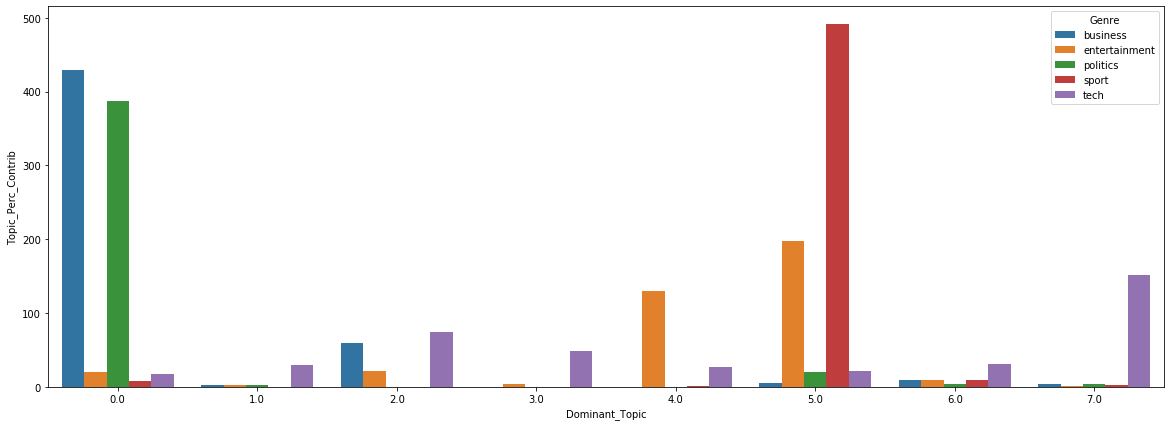

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,7))
sns.barplot(x=topics.Dominant_Topic, y="Topic_Perc_Contrib", hue='Genre',data=topics)
plt.savefig('../../Bilder/Topic Modeling/topic_modelling_verteilung')
plt.show()

In [53]:
for i, v in Counter(df_dominant_topic[df_dominant_topic.Genre=='tech'].Dominant_Topic).items():
    print(f"Topic {i} tritt {v} mal auf")

Topic 0.0 tritt 17 mal auf
Topic 3.0 tritt 49 mal auf
Topic 4.0 tritt 27 mal auf
Topic 7.0 tritt 152 mal auf
Topic 6.0 tritt 31 mal auf
Topic 1.0 tritt 30 mal auf
Topic 2.0 tritt 74 mal auf
Topic 5.0 tritt 21 mal auf


### Repräsentativstes Dokument pro Topic

In [47]:
import numpy as np
representative = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    representative = pd.concat([representative, grp.sort_values(['Perc_Contribution']).head(1)], axis=0)
representative.reset_index(drop=True, inplace=True)

representative.columns = [
   'Topic_Number', "Contribution_Perc", "Keywords", "Text", "Genre", "Artist"
]
representative

,Topic_Number,Contribution_Perc,Keywords,Text,Genre,Artist
0,0.0,0.2285,"government, year, %, new, public, country, las...",New anti - fraud Anti - present confidential p...,business,236.txt
1,1.0,0.2524,"system, are_are, site, net, many, other, file,...",free Scan hard ultimate appropriate illegal Ma...,tech,091.txt
2,2.0,0.2464,"%, music, year, new, digital, market, technolo...",secondary illegal wide British young unscrupul...,entertainment,148.txt
3,3.0,0.2700,"security, software, e_-_mail, spam, %, firm, n...",dead dizzy legal wrong dead crazy same Past li...,entertainment,209.txt
4,4.0,0.3040,"TV, film, high, next, world, year, television,...",legitimate key different legitimate own able o...,tech,104.txt
5,5.0,0.2490,"game, time, first, last, year, old, world, goo...",dark unmistakable rare annual first small inde...,entertainment,032.txt
6,6.0,0.2375,"legal, software, company, action, law, case, n...",German last new such irreversible willing clas...,entertainment,271.txt
7,7.0,0.2931,"mobile, technology, phone, other, new, such, w...",open able new intellectual further available T...,tech,268.txt


In [48]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

cv = CountVectorizer(max_features=2000, min_df=1, max_df=300, stop_words='english')
cv.fit(representative['Keywords'])

results = cv.transform(representative['Keywords'])

features = cv.get_feature_names()

In [49]:
df_res = pd.DataFrame(results.toarray(), columns=features)
# df_res = df_res.set_index(df.genre1)
df_res

,_mail,action,are_are,case,company,computer,country,definition,digital,e_,...,spam,technology,television,time,tv,virus,way,week,world,year
0,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,1,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1,1
6,0,1,0,1,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7,0,0,1,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


In [50]:
df_res.loc['sum']=df_res.sum()
df_res = df_res.div(df_res.sum(axis=1), axis=0)
df_res.sort_values(by=['sum'], axis=1, inplace=True, ascending=False)
df_res

,new,year,are_are,technology,time,net,world,software,company,computer,...,mobile,good,government,high,information,internet,law,legal,market,music
0,0.125000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,...,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.166667,0.166667,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.125000,0.125000,0.125000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.125000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.100000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.125000,0.125000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.125000,0.000000,0.000000,0.125000,0.000000,0.125000,0.000000,0.000000,0.000000,...,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.100000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.100000,0.100000,0.100000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.100000,0.100000,0.000000,0.000000
7,0.125000,0.000000,0.125000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,...,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sum,0.075758,0.060606,0.045455,0.045455,0.030303,0.030303,0.030303,0.030303,0.030303,0.030303,...,0.015152,0.015152,0.015152,0.015152,0.015152,0.015152,0.015152,0.015152,0.015152,0.015152


In [54]:
genre = df_res[df_res.index==7]
genre.loc['sum']=genre.sum()
genre = genre.div(genre.sum(axis=1), axis=0)
genre.sort_values(by=['sum'], axis=1, inplace=True, ascending=False)
genre

,new,computer,way,service,phone,mobile,are_are,technology,law,file,...,spam,public,report,security,tv,site,old,week,year,music
7,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


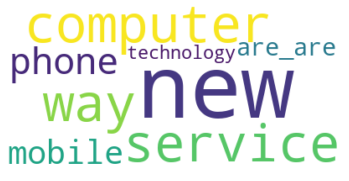

In [55]:
from wordcloud import WordCloud

def makeImage(text, figname):
    wc = WordCloud(background_color="white", max_words=1000)
    # generate word cloud
    wc.generate_from_frequencies(text)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(figname)
    plt.show()

text = genre.loc['sum']
# text = abba.any()
makeImage(text, "../../Bilder/Topic Modeling/wordcloud_Topic7")